# Gradient Descent vs. Stochastic Gradient Descent

## Gradient Descent (GD)
Gradient Descent is an **iterative optimization algorithm** used to minimize a loss function.  
- At each step, we compute the gradient of the loss with respect to **all training data**.  
- The parameters are updated in the opposite direction of the gradient.  

**Update rule:**
\[
$\theta \; \leftarrow \; \theta - \eta \, \nabla_\theta J(\theta)$
\]  

- \($\theta$\): parameters  
- \($\eta$\): learning rate  
- \($J(\theta)$\): loss function  

**Pros:**
- Stable convergence.  
- Direction always based on the true full gradient.  

**Cons:**
- Expensive for large datasets (must use all data every step).  

---

## Stochastic Gradient Descent (SGD)
Stochastic Gradient Descent uses a **random subset** of the data (a single sample or a small batch) at each step.  
- Instead of the full gradient, we approximate it using only the batch.  
- Updates are much faster and noisier, but this noise can help escape local minima.  

**Update rule:**
\[
$\theta \; \leftarrow \; \theta - \eta \, \nabla_\theta J(\theta; x_i, y_i)$
\]  

(where \($(x_i, y_i)$\) is a single data point, or a mini-batch).  

**Pros:**
- Much faster per update.  
- Scales well to large datasets.  
- Can escape poor local minima.  

**Cons:**
- Noisier convergence.  
- Requires tuning learning rate & batch size.  

---

## Summary
- **Gradient Descent (GD):** full dataset each step → accurate but slow.  
- **Stochastic GD (SGD):** sample/mini-batch each step → fast, scalable, noisier.  
- In practice, **mini-batch SGD** is most common, balancing efficiency and stability.  


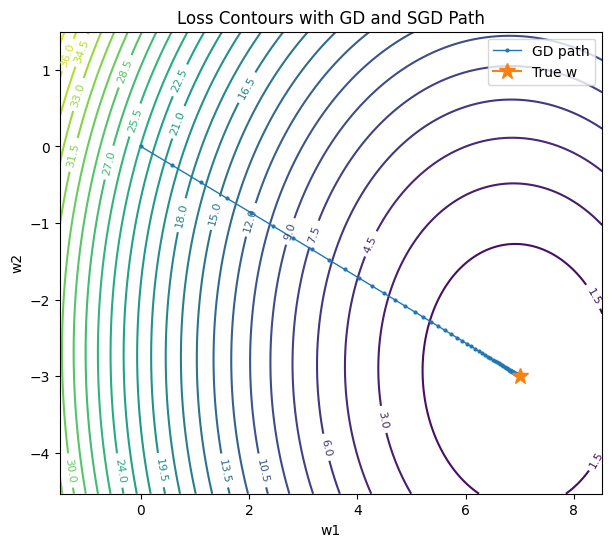

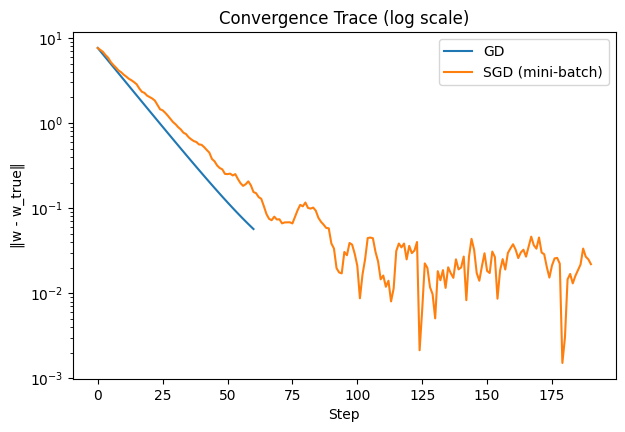

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ----- Synthetic 2D linear regression data -----
rng = np.random.default_rng(7)
N, d = 300, 2
X = rng.normal(size=(N, d))
w_true = np.array([7.0, -3.0])
y = X @ w_true + rng.normal(scale=0.6, size=N)

# ----- Loss + gradients -----
def loss_mse(w, X, y):
    r = X @ w - y
    return 0.5 * np.mean(r**2)

def grad_full(w, X, y):
    r = X @ w - y
    return (X.T @ r) / len(y)

def grad_batch(w, Xb, yb):
    r = Xb @ w - yb
    return (Xb.T @ r) / len(yb)

# ----- Run GD -----
def run_gd(lr=0.1, iters=60):
    w = np.zeros(d)
    path = [w.copy()]
    for _ in range(iters):
        w -= lr * grad_full(w, X, y)
        path.append(w.copy())
    return np.array(path)

# ----- Run SGD -----
def run_sgd(lr=0.08, epochs=10, batch_size=16, seed=0):
    rng_local = np.random.default_rng(seed)
    w = np.zeros(d)
    path = [w.copy()]
    for _ in range(epochs):
        idx = rng_local.permutation(N)
        for start in range(0, N, batch_size):
            sel = idx[start:start+batch_size]
            w -= lr * grad_batch(w, X[sel], y[sel])
            path.append(w.copy())
    return np.array(path)

gd_path = run_gd()
sgd_path = run_sgd()

# ----- Build loss surface grid -----
all_w = np.vstack([gd_path, sgd_path, w_true.reshape(1, -1)])
w1_min, w2_min = all_w.min(axis=0) - 1.5
w1_max, w2_max = all_w.max(axis=0) + 1.5

w1 = np.linspace(w1_min, w1_max, 200)
w2 = np.linspace(w2_min, w2_max, 200)
W1, W2 = np.meshgrid(w1, w2)

Z = np.empty(W1.shape)
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        Z[i, j] = loss_mse(np.array([W1[i, j], W2[i, j]]), X, y)


plt.figure(figsize=(7, 6))
cs2 = plt.contour(W1, W2, Z, levels=25)
plt.clabel(cs2, inline=True, fontsize=8)

plt.plot(gd_path[:, 0], gd_path[:, 1], marker="o", markersize=2,
         linewidth=1, label="GD path")
# plt.plot(sgd_path[:, 0], sgd_path[:, 1], marker="o", markersize=2,
        #  linewidth=1, label="SGD (mini-batch) path")
plt.plot([w_true[0]], [w_true[1]], marker="*", markersize=12,
         label="True w")

plt.xlabel("w1")
plt.ylabel("w2")
plt.title("Loss Contours with GD and SGD Path")
plt.legend()
plt.show()


# Helper: distance to true parameters
def error_to_true(path, w_true):
    return np.linalg.norm(path - w_true, axis=1)

gd_err = error_to_true(gd_path, w_true)
sgd_err = error_to_true(sgd_path, w_true)

plt.figure(figsize=(7, 4.5))
plt.plot(gd_err, label="GD")
plt.plot(sgd_err, label="SGD (mini-batch)")
plt.yscale("log")  # log scale helps visualize convergence
plt.xlabel("Step")
plt.ylabel("‖w - w_true‖")
plt.title("Convergence Trace (log scale)")
plt.legend()
plt.show()